![caption](images/02Q.png)

## Outline - Feature-based Image Registration

#### Explain Feature-based Image Registration:
1. The task is to translate similar images to the same coordinate system. That is given two images depicting the same object, we want to find a transformation that aligns the two object.
    * Lets consider a reference image and a moving image depicting the same object. In this case the task is to pick a scale, rotation and translation of the moving image to match the reference image.
2. How is this done?
    * (Unique) scale-invariant(!) keypoints are extracted from each image.
    * The keypoints are matched in a least squares fashion.
    * A scale, rotation and translation is found as the ones minimizing the sum of squared errors. Analytical solutions in closed form exists for these transformations.

#### Approach:
1. First we implement a function that given a matching of two point sets p and q, finds scale, rotation and translation which minimizes:
$\sum_i (\mathbf{q_i} - (s\mathbf{R p_i} + \mathbf{t}))^2$
    * We validate the implementation by generating random points, subjecting them to a known rotation, and using the implemented function to rotate back.
2. Next we extract SIFT features from an image. Important notes on these are:
    * First scalespace blob detection is run with the difference of gaussian kernel as being an approximation of the normalised scale space Laplacian. From this potential keypoints are extracted. (assigns scale and location)
    * Secodly points with low contrast (easily cubject to noise) are removed.
    * Thirdly the difference of Gaussians will have strong response near edges. i.e. high principal curvature. We therefor filter the keypoints using the ratio of principal curvature. 
    and a known transformation of said image, using the functions supplied.
    * Now an orientation is assigned to each keypoint using local information. (invariance of orientation)
    * Having determined the keypoints, a 128 descriptor is calculated for each keypoint. This descriptor should be interpreted as 8 histograms on a 4x4 array.
    
#### Key take aways:
1. We can see, that we using SIFT features in general obtain good matchings.
2. Outliers can however affect the result significantly, and must be dealt with.

### 4.1.1 Implement function to find scale, rotation and translation.

In [1]:
# Helpers
import numpy as np
import matplotlib.pyplot as plt
import math

############ Create test points ####################
def get_points(n):
    return np.random.randint(low=-20, high=20, size=n), np.random.randint(low=-20, high=20, size=n)
n = 1000
x,y = get_points(n)

def rotate_origin_only(xy, radians):
    """Only rotate a point around the origin (0, 0)."""
    x, y = xy
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

# Rotate:
rotated_x = []
rotated_y = []
for point in zip(x,y):
    new_x, new_y = rotate_origin_only(point, 0.25)
    rotated_x.append(new_x)
    rotated_y.append(new_y)
rotated_x = np.array(rotated_x)
rotated_y = np.array(rotated_y)
    
# Scale:
s = 0.5
s_r_x = rotated_x*s
s_r_y = rotated_y*s

# Translation:
t_s_r_x = s_r_x + 5
t_s_r_y = s_r_y + 10

p = np.array([x, y])
q = np.array([t_s_r_x, t_s_r_y])

############ Define transformation ####################

def findTransformation(p, q):
    # Find scale parameter
    centroid_p = np.mean(p, axis=1).reshape(2,1)
    centroid_q = np.mean(q, axis=1).reshape(2,1)
    p_norms = np.array(list(map(lambda x: np.sqrt(np.matmul(np.transpose(x), x)), np.transpose(p-centroid_p))))
    q_norms = np.array(list(map(lambda x: np.sqrt(np.matmul(np.transpose(x), x)), np.transpose(q-centroid_q))))
    s = np.sum(q_norms)/np.sum(p_norms)
    
    # Find rotation matrix:
    C = np.matmul(np.subtract(q,centroid_q.reshape(2,1)),np.transpose(np.subtract(p,centroid_p.reshape(2,1))))
    # Singular value decomp:
    u, _, vh = np.linalg.svd(C)
    R_hat = np.matmul(u, vh)
    D = np.array([[1,0],[0,np.linalg.det(R_hat)]])
    # Rotation:
    R = np.matmul(R_hat, D)
    
    # Find translation:
    t = centroid_q - s*np.matmul(R, centroid_p)
    
    return(s, R, t)

s, R, t = findTransformation(q, p)

# Tranform points back to the original:
t_m = s*np.matmul(R, q)+t

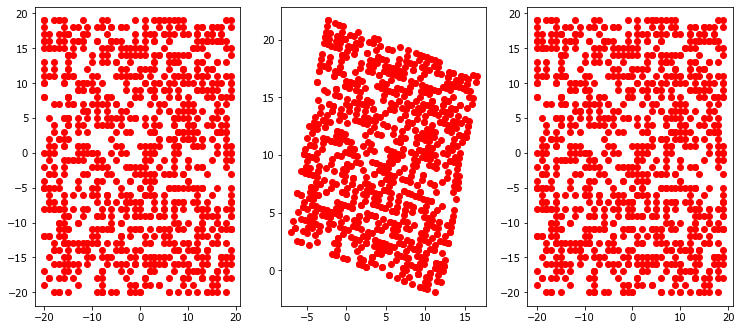

In [2]:
# Transformation plot:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(12.5, 5.5, forward=True)
ax[0].plot(x, y, 'ro')
ax[1].plot(t_s_r_x, t_s_r_y, 'ro')
ax[2].plot(t_m[0], t_m[1], 'ro')

## Exercise 4.2 - SIFT feature matching

We will first consider the images:

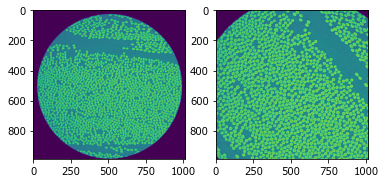

In [3]:
#
import cv2
import pysift as sift
import imutils
# Load data
img = cv2.imread('EX_4_data/CT_lab_high_res.png', cv2.IMREAD_GRAYSCALE)
img_t = imutils.rotate_bound(img, 45)[300:1000,300:1000]
img_t = cv2.resize(img_t, (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img)
ax[1].imshow(img_t)

We first extract the SIFT features:

In [4]:
# Extract sift keypoints and descriptors
kp_org, dsc_org = sift.computeKeypointsAndDescriptors(img)
kp_rotated, dsc_rotated = sift.computeKeypointsAndDescriptors(img_t)

In [5]:
# Create function to normalize and threshold descriptor
# Normalization is done to obtain contrast invariance.
# Thresholding: Reduce influence of large gradients. Consequence of non-linear illumination changes.
def normalizeAndThresh(des):
    # Normalize to unit length
    des = des/np.sqrt(np.sum(des**2))
    
    # thresholding
    des[des>0.2] = 0.2
    
    # Normalizing again
    des = des/np.sqrt(np.sum(des**2))
    return des

In [6]:
# Match features
NO_FILTERING = 0
FILTERING = 1
SYMMETRY = 2

def match_images(im1, im2, match_type, eta_lim = 0.6):
    if match_type == NO_FILTERING:
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = matcher.match(im1,im2)
    elif match_type == FILTERING:
        matcher = cv2.BFMatcher()
        matches = np.array(matcher.knnMatch(im1, im2, k=2))
        eta = np.array([match[0].distance / match[1].distance for match in matches])
        matches = matches[eta < eta_lim, 0]
    elif match_type == SYMMETRY:
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = matcher.match(im1,im2)
        
    return sorted(matches, key = lambda x:x.distance)

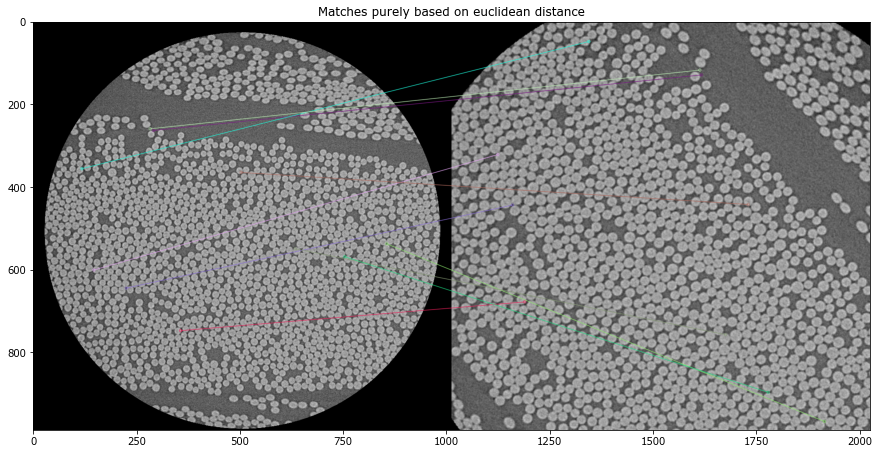

In [7]:
# Normalize and threshold descriptors
dsc_org_normalized = normalizeAndThresh(dsc_org)
dsc_rotated_normalized = normalizeAndThresh(dsc_rotated)

# Match image keypoints based on their descriptor 
matches = match_images(dsc_org_normalized, dsc_rotated_normalized, FILTERING)

# Illustrate matches
plt.figure(figsize=(15,15))
plt.imshow(cv2.drawMatches(img, kp_org, img_t, kp_rotated, matches[:10], None, flags=2))
plt.title('Matches purely based on euclidean distance')
plt.show()

In [8]:
# We tranform the extracted keypoints:
def getKeyPointCoord(kp_org, kp_rotated, matches):
    pic1 = []
    pic2 = []
    for i, match in enumerate(matches):
        kp1 = np.array(kp_org[match.queryIdx].pt)
        kp2 = np.array(kp_rotated[match.trainIdx].pt)
        pic1.append(kp1)
        pic2.append(kp2)
    pic1 = np.array(pic1).transpose()
    pic2 = np.array(pic2).transpose()
    return(pic1, pic2)

pic1, pic2 = getKeyPointCoord(kp_org, kp_rotated, matches)
# Find the transformation from pic2 -> pic1
s, R, t = findTransformation(pic1, pic2)
pic3 = s*np.matmul(R, pic1)+t

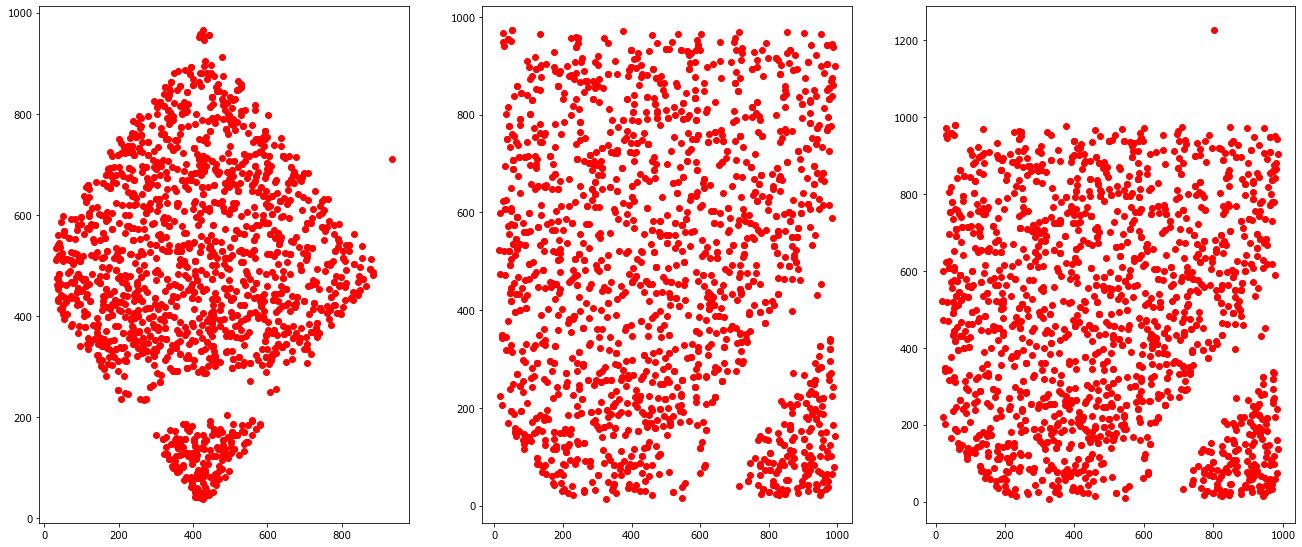

In [9]:
# A plot of the transformed features:
fig1, ax1 = plt.subplots(1,3)
fig1.set_size_inches(22.5, 9.5, forward=True)
ax1[0].plot(pic1[0], pic1[1], 'ro')
ax1[1].plot(pic2[0], pic2[1], 'ro')
ax1[2].plot(pic3[0], pic3[1], 'ro')

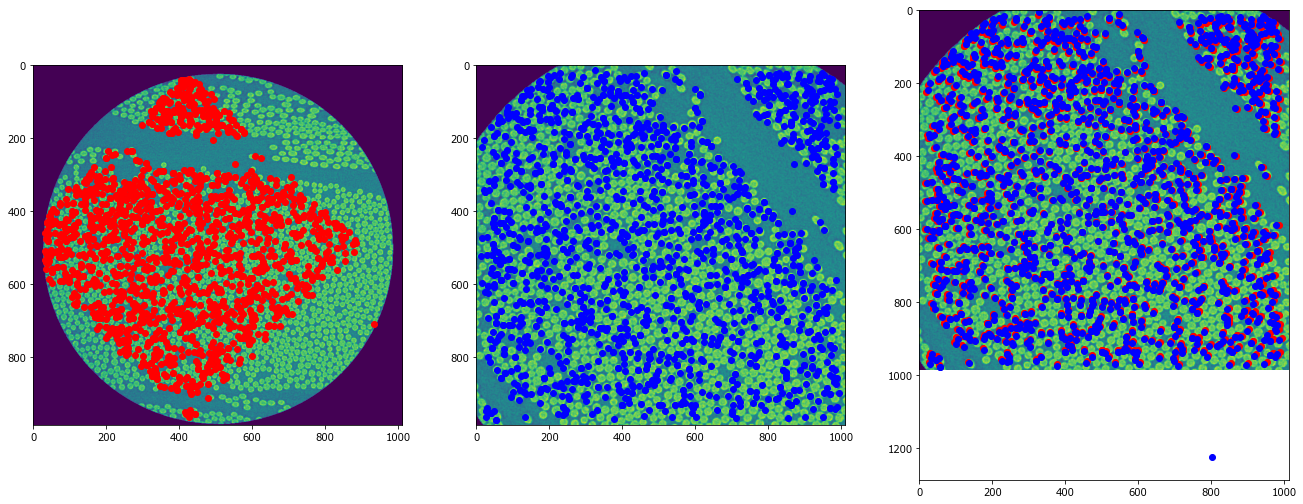

In [10]:
#
fig2, ax2 = plt.subplots(1,3)
fig2.set_size_inches(22.5, 9.5, forward=True)

ax2[0].imshow(img)
ax2[0].scatter(pic1[0], pic1[1], c='red')

ax2[1].imshow(img_t)
ax2[1].scatter(pic2[0], pic2[1], c='blue')

ax2[2].imshow(img_t)
ax2[2].scatter(pic2[0], pic2[1], c='red')
ax2[2].scatter(pic3[0], pic3[1], c='blue')


## Extract and match features for different resolutions:

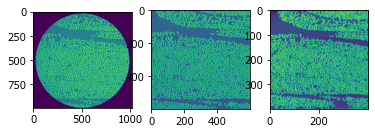

In [11]:
# Import different res pictures:
img_h = cv2.imread('EX_4_data/CT_lab_high_res.png', cv2.IMREAD_GRAYSCALE)
img_m = cv2.imread('EX_4_data/CT_lab_med_res.png', cv2.IMREAD_GRAYSCALE)
img_l = cv2.imread('EX_4_data/CT_lab_low_res.png', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img_h)
ax[1].imshow(img_m)
ax[2].imshow(img_l)

In [12]:
#First we compute the descriptors and keypoints and find matches
kp_h, des_h = sift.computeKeypointsAndDescriptors(img_h)
kp_m, des_m = sift.computeKeypointsAndDescriptors(img_m)
kp_l, des_l = sift.computeKeypointsAndDescriptors(img_l)

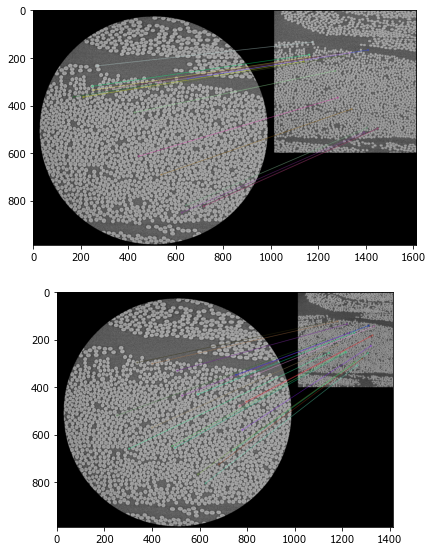

In [93]:
# Normalize and threshold descriptors
des_h_norm = normalizeAndThresh(des_h)
des_m_norm = normalizeAndThresh(des_m)
des_l_norm = normalizeAndThresh(des_l)

# Match image keypoints based on their descriptor 
matches_hm = match_images(des_h_norm, des_m_norm, FILTERING)
matches_hl = match_images(des_h_norm, des_l_norm, FILTERING, eta_lim=0.8)

# Illustrate matches
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(22.5, 9.5, forward=True)

ax[0].imshow(cv2.drawMatches(img_h, kp_h, img_m, kp_m, matches_hm[:20], None, flags=2))
ax[1].imshow(cv2.drawMatches(img_h, kp_h, img_l, kp_l, matches_hl[:20], None, flags=2))


In [94]:
# Get keypoint coordinates for the images:
pic_hm, pic_m = getKeyPointCoord(kp_h, kp_m, matches_hm)
pic_hl, pic_l = getKeyPointCoord(kp_h, kp_l, matches_hl)

# Find the transformation from pic2 -> pic1
s1, R1, t1 = findTransformation(pic_hm, pic_m)
s2, R2, t2 = findTransformation(pic_hl, pic_l)

# Transform the image
pic_hm_t = s1*np.matmul(R1, pic_hm)+t1
pic_hl_t = s2*np.matmul(R2, pic_hl)+t2

# Find the transformation from pic2 -> pic1
#s1, R1, t1 = findTransformation(pic_m, pic_hm)
#s2, R2, t2 = findTransformation(pic_l, pic_hl)

# Transform the image
#pic_hm_t = s1*np.matmul(R1, pic_m)+t1
#pic_hl_t = s2*np.matmul(R2, pic_l)+t2

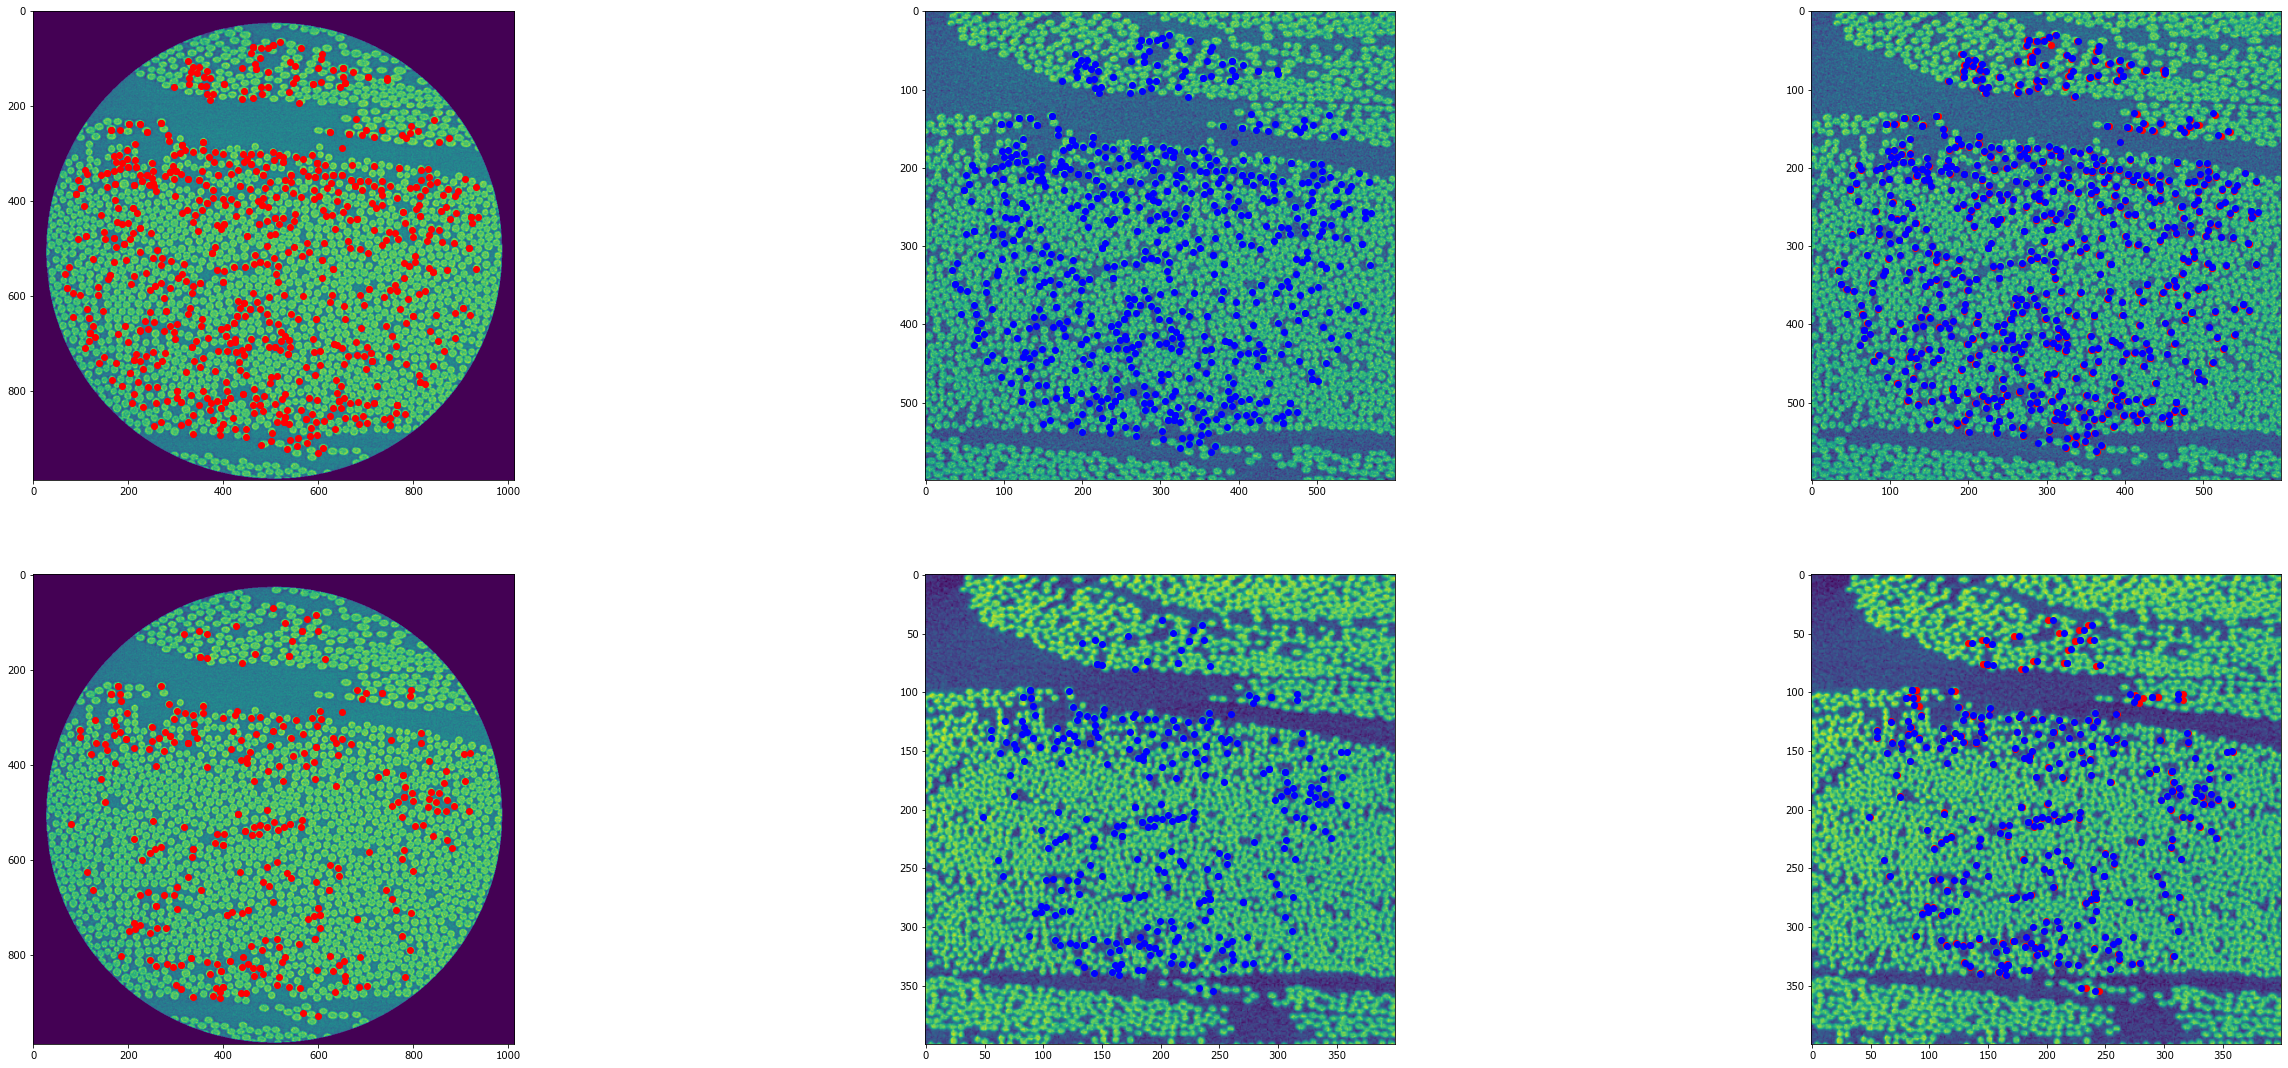

In [126]:
# 
fig2, ax2 = plt.subplots(2,3)
fig2.set_size_inches(2*22.5, 2*9.5, forward=True)

ax2[0,0].imshow(img_h)
ax2[0,0].scatter(pic_hm[0], pic_hm[1], c='red')

ax2[0,1].imshow(img_m)
ax2[0,1].scatter(pic_m[0], pic_m[1], c='blue')

ax2[0,2].imshow(img_m)
ax2[0,2].scatter(pic_m[0], pic_m[1], c='red')
ax2[0,2].scatter(pic_hm_t[0], pic_hm_t[1], c='blue')

#ax2[0,2].imshow(img_h)
#ax2[0,2].scatter(pic_hm[0], pic_hm[1], c='red')
#ax2[0,2].scatter(pic_hm_t[0], pic_hm_t[1], c='blue')

ax2[1,0].imshow(img_h)
ax2[1,0].scatter(pic_hl[0], pic_hl[1], c='red')

ax2[1,1].imshow(img_l)
ax2[1,1].scatter(pic_l[0], pic_l[1], c='blue')

ax2[1,2].imshow(img_l)
ax2[1,2].scatter(pic_l[0], pic_l[1], c='red')
ax2[1,2].scatter(pic_hl_t[0], pic_hl_t[1], c='blue')

#ax2[1,2].imshow(img_h)
#ax2[1,2].scatter(pic_hl[0], pic_hl[1], c='red')
#ax2[1,2].scatter(pic_hl_t[0], pic_hl_t[1], c='blue')


## Attempt to increase precision:

In [180]:
# 
from functools import reduce
# Removes outliers from the pointsets:
def removeOutliers(p, q):
    diff = (p-q).transpose()
    dists = list(map(lambda x: math.sqrt(x[0]**2+x[1]**2), diff))
    m = np.mean(np.array(dists))
    print("Mean dist: ", m)
    # Pick only points that are closer than 3*mean
    lst = zip(dists, list(range(len(dists))))
    idxs = np.array(list(map(lambda x: x[1], list(filter(lambda x: x[0] < 2*m, lst))))).transpose()
    return dists, idxs #p_new, q_new, 
#dists1, m, pic2_new, pic3_new = removeOutliers(pic2, pic3)
#dists2, m, pic2_new2, pic3_new2 = removeOutliers(pic2_new, pic3_new)
#fig, ax = plt.subplots(1,2)
#ax[0].hist(dists1, bins=range(0,int(np.max(dists1))+1))
#ax[1].hist(dists2, bins=range(0,int(np.max(dists2))+1))

Mean dist:  1.9048932783420138
Mean dist:  0.7544079722532184


(array([225.,  49.,   1.,   0.,   0.,   4.,  12.,  12.,   2.,   6.]),
 array([0.04344063, 0.5411912 , 1.03894176, 1.53669233, 2.03444289,
        2.53219346, 3.02994402, 3.52769459, 4.02544516, 4.52319572,
        5.02094629]),
 <a list of 10 Patch objects>)

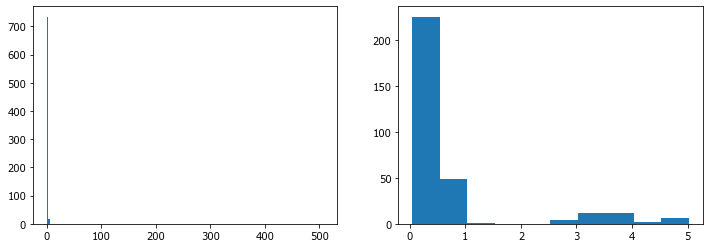

In [181]:
# Get indicies of not outliers:
dists1, idxs_hm = removeOutliers(pic_m, pic_hm_t)
dists2, idxs_hl = removeOutliers(pic_l, pic_hl_t)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4)
ax[0].hist(dists1, bins=200)
ax[1].hist(dists2)

In [182]:
# Reduce the keypoint sets:
pic_hm_reduced = np.array([pic_hm.transpose()[i] for i in idxs_hm]).transpose()
pic_m_reduced = np.array([pic_m.transpose()[i] for i in idxs_hm]).transpose()
pic_hl_reduced = np.array([pic_hl.transpose()[i] for i in idxs_hl]).transpose()
pic_l_reduced = np.array([pic_l.transpose()[i] for i in idxs_hl]).transpose()

# Calculate a new transformation:
s1_r, R1_r, t1_r = findTransformation(pic_hm_reduced, pic_m_reduced)
s2_r, R2_r, t2_r = findTransformation(pic_hl_reduced, pic_l_reduced)

# Transform the image
pic_hm_t_r = s1_r*np.matmul(R1_r, pic_hm_reduced)+t1_r
pic_hl_t_r = s2_r*np.matmul(R2_r, pic_hl_reduced)+t2_r

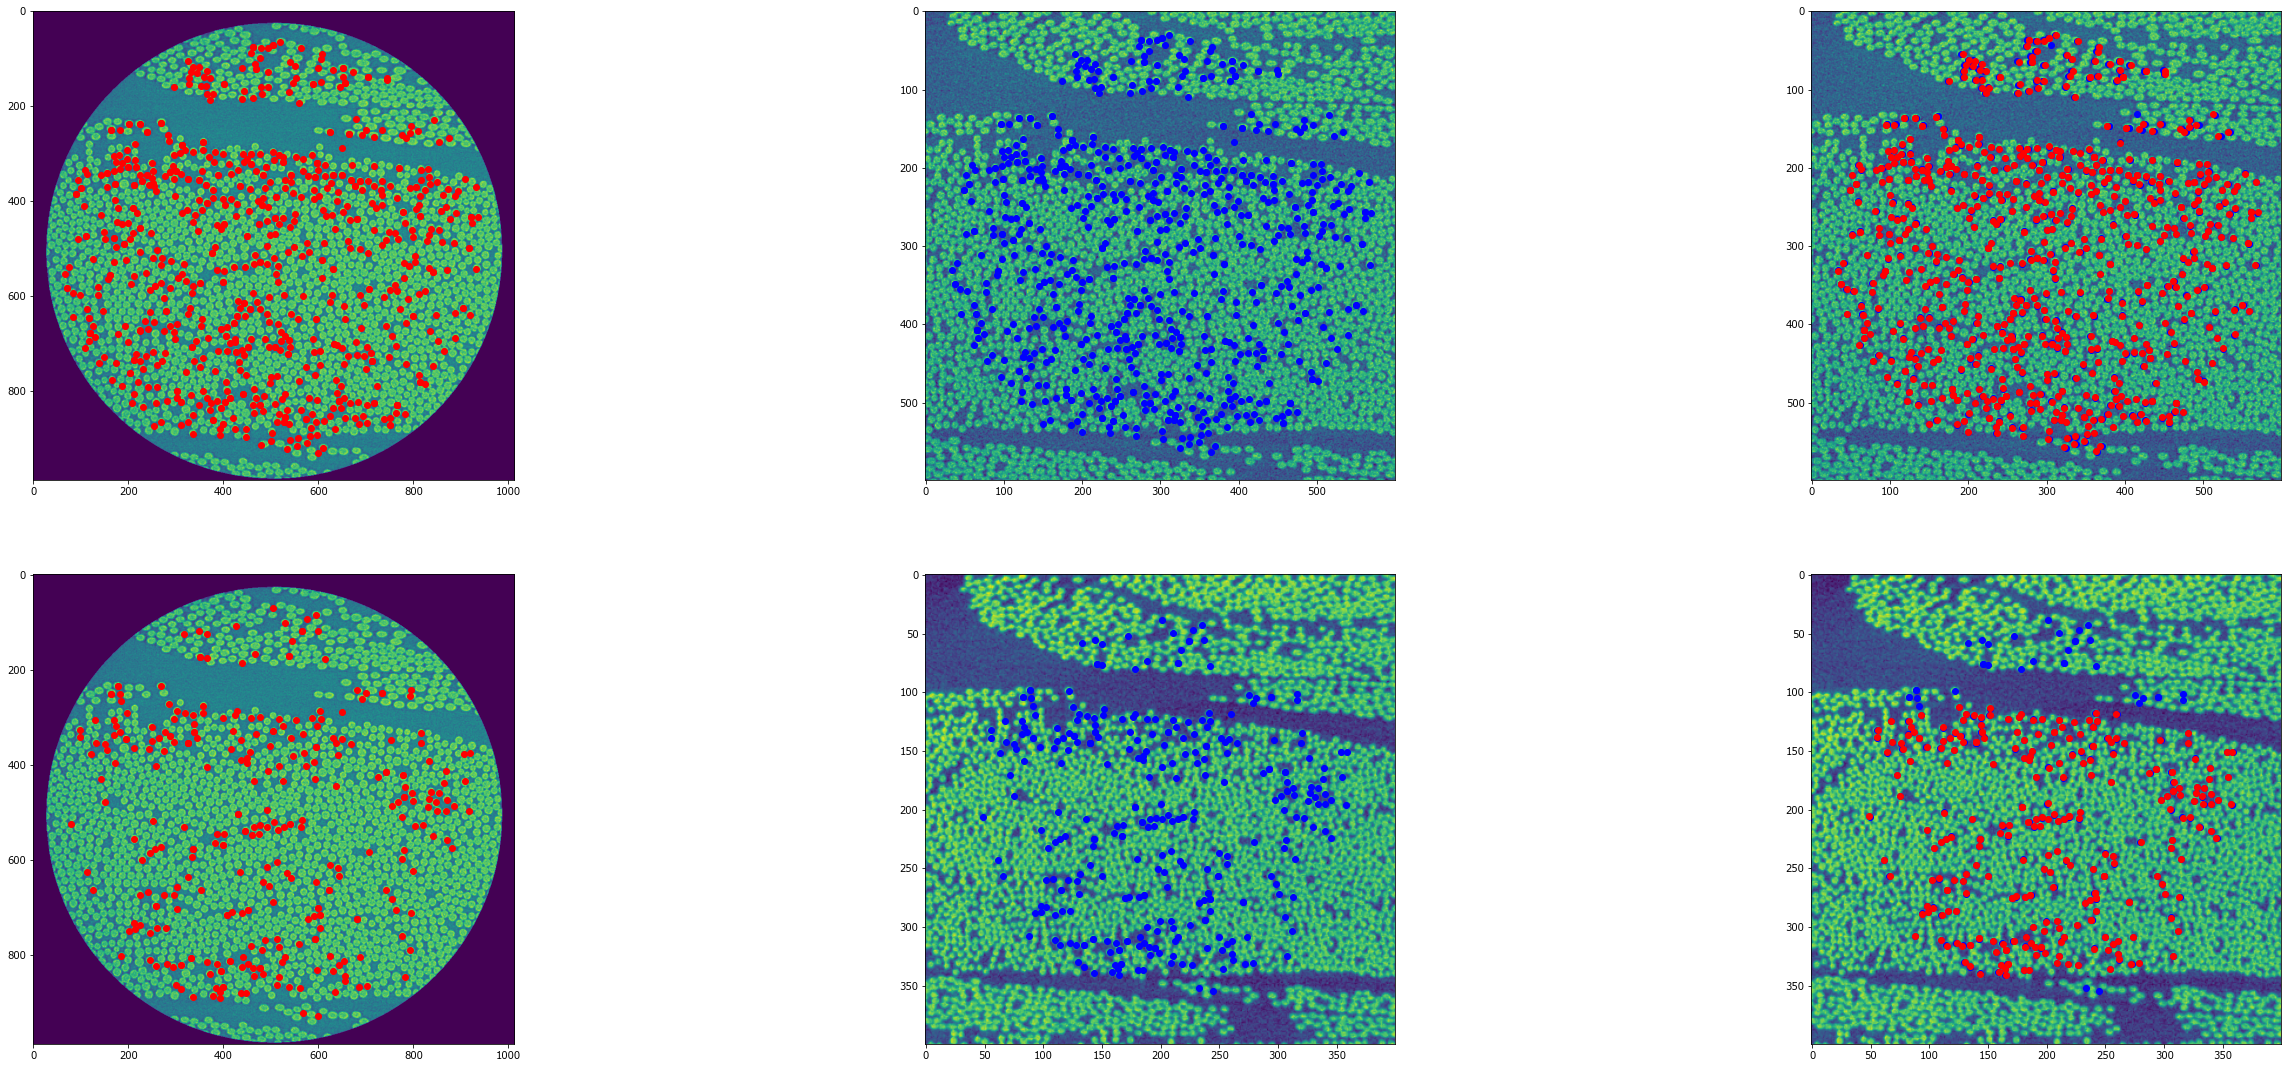

In [183]:
# Visualize the new transformation:
fig2, ax2 = plt.subplots(2,3)
fig2.set_size_inches(2*22.5, 2*9.5, forward=True)

ax2[0,0].imshow(img_h)
ax2[0,0].scatter(pic_hm[0], pic_hm[1], c='red')

ax2[0,1].imshow(img_m)
ax2[0,1].scatter(pic_m[0], pic_m[1], c='blue')

ax2[0,2].imshow(img_m)
ax2[0,2].scatter(pic_m[0], pic_m[1], c='blue')
ax2[0,2].scatter(pic_hm_t_r[0], pic_hm_t_r[1], c='red')

ax2[1,0].imshow(img_h)
ax2[1,0].scatter(pic_hl[0], pic_hl[1], c='red')

ax2[1,1].imshow(img_l)
ax2[1,1].scatter(pic_l[0], pic_l[1], c='blue')

ax2[1,2].imshow(img_l)
ax2[1,2].scatter(pic_l[0], pic_l[1], c='blue')
ax2[1,2].scatter(pic_hl_t_r[0], pic_hl_t_r[1], c='red')

